# [E-06] 영화리뷰 텍스트 감성분석하기

이번 프로젝트는 네이버 영화의 댓글을 모아 구성된 데이터셋인 Naver sentiment movie corpus를 활용하여 한국어 텍스트의 감정 분석을 하는 것을 목표로 한다.

<hr>

## 데이터 준비

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

In [2]:
import pandas as pd

# 데이터 살펴보기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<hr>

## 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=15000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글과 공백만 나오게
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 대체
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글과 공백만 나오게
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 대체
    test_data = test_data.dropna(how = 'any')  # 결측치 제거
    
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(15000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_6908/3384109154.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글과 공백만 나오게
/tmp/ipykernel_6908/3384109154.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글과 공백만 나오게


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환하는 함수 
# 단, 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode하는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

<hr>

## 모델 구성을 위한 데이터 분석 및 가공


### 데이터셋 내 문장 길이 분포

In [6]:
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866


### 적절한 최대 문장 길이 지정

In [7]:
# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', 
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(x_train.shape)

(145791, 36)


<hr>

## validation set 구성

In [9]:
# validation set 35000건 분리
x_val = x_train[:35000]   
y_val = y_train[:35000]

# train set으로 사용될 나머지
partial_x_train = x_train[35000:]  
partial_y_train = y_train[35000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(110791, 36)
(110791,)


<hr>

## 모델 구성

모델은 RNN, 1-D CNN, GlobalMaxPooling1D()를 활용한 세 가지 모델을 사용할 예정이다.

<hr>

## 1) RNN 모델 (LSTM)

### 모델 설계

In [10]:
vocab_size = 15000  # 어휘 사전의 크기
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))   # LSTM state 벡터의 차원수
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,030,097
Trainable params: 3,030,097
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
217/217 [==============================] - 5s 9ms/step - loss: 0.5253 - accuracy: 0.7328 - val_loss: 0.3719 - val_accuracy: 0.8368
Epoch 2/10
217/217 [==============================] - 2s 7ms/step - loss: 0.3380 - accuracy: 0.8552 - val_loss: 0.3506 - val_accuracy: 0.8457
Epoch 3/10
217/217 [==============================] - 2s 7ms/step - loss: 0.2951 - accuracy: 0.8754 - val_loss: 0.3582 - val_accuracy: 0.8455
Epoch 4/10
217/217 [==============================] - 2s 7ms/step - loss: 0.2595 - accuracy: 0.8897 - val_loss: 0.3724 - val_accuracy: 0.8464
Epoch 5/10
217/217 [==============================] - 2s 7ms/step - loss: 0.2309 - accuracy: 0.9019 - val_loss: 0.4033 - val_accuracy: 0.8432
Epoch 6/10
217/217 [==============================] - 2s 7ms/step - loss: 0.2079 - accuracy: 0.9121 - val_loss: 0.4203 - val_accuracy: 0.8412
Epoch 7/10
217/217 [==============================] - 2s 7ms/step - loss: 0.1896 - accuracy: 0.9195 - val_loss: 0.4433 - val_accuracy: 0.8387
Epoch 

### 모델 평가

In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.5346 - accuracy: 0.8332
[0.5345679521560669, 0.8332074880599976]


### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


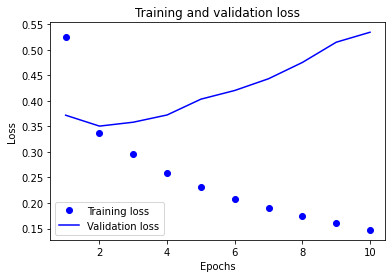

In [13]:
# loss 시각화
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

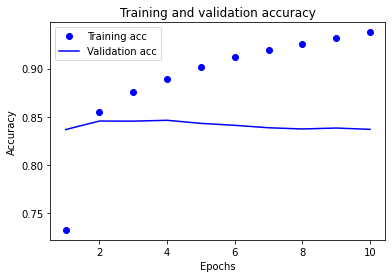

In [14]:
# accuracy 시각화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<hr>

## 2) 1-D CNN 모델

### 모델 설계

In [15]:
vocab_size = 15000  
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          19216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 모델 학습

In [16]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
217/217 [==============================] - 4s 8ms/step - loss: 0.4596 - accuracy: 0.7803 - val_loss: 0.3556 - val_accuracy: 0.8427
Epoch 2/10
217/217 [==============================] - 1s 6ms/step - loss: 0.3127 - accuracy: 0.8681 - val_loss: 0.3467 - val_accuracy: 0.8503
Epoch 3/10
217/217 [==============================] - 1s 6ms/step - loss: 0.2485 - accuracy: 0.9013 - val_loss: 0.3674 - val_accuracy: 0.8479
Epoch 4/10
217/217 [==============================] - 1s 7ms/step - loss: 0.1786 - accuracy: 0.9336 - val_loss: 0.4096 - val_accuracy: 0.8388
Epoch 5/10
217/217 [==============================] - 1s 7ms/step - loss: 0.1212 - accuracy: 0.9567 - val_loss: 0.4945 - val_accuracy: 0.8356
Epoch 6/10
217/217 [==============================] - 1s 6ms/step - loss: 0.0823 - accuracy: 0.9722 - val_loss: 0.5611 - val_accuracy: 0.8295
Epoch 7/10
217/217 [==============================] - 1s 7ms/step - loss: 0.0596 - accuracy: 0.9803 - val_loss: 0.6512 - val_accuracy: 0.8277
Epoch 

### 모델 평가

In [17]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.8919 - accuracy: 0.8214
[0.8919496536254883, 0.8214103579521179]


### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


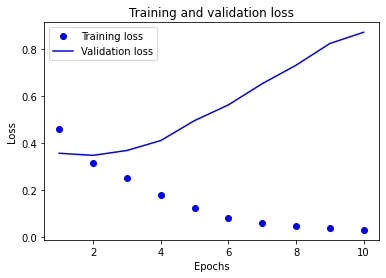

In [18]:
# loss 시각화
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

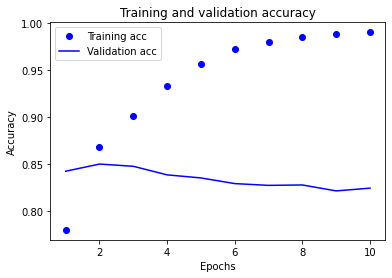

In [19]:
# accuracy 시각화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<hr>

## 3) GlobalMaxPooling1D()를 활용한 모델

### 모델 설계

In [20]:
vocab_size = 15000
word_vector_dim = 200   

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,001,617
Trainable params: 3,001,617
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
217/217 [==============================] - 2s 5ms/step - loss: 0.4823 - accuracy: 0.7980 - val_loss: 0.3569 - val_accuracy: 0.8425
Epoch 2/10
217/217 [==============================] - 1s 5ms/step - loss: 0.3187 - accuracy: 0.8646 - val_loss: 0.3444 - val_accuracy: 0.8501
Epoch 3/10
217/217 [==============================] - 1s 5ms/step - loss: 0.2625 - accuracy: 0.8938 - val_loss: 0.3497 - val_accuracy: 0.8517
Epoch 4/10
217/217 [==============================] - 1s 5ms/step - loss: 0.2140 - accuracy: 0.9178 - val_loss: 0.3699 - val_accuracy: 0.8483
Epoch 5/10
217/217 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9403 - val_loss: 0.3999 - val_accuracy: 0.8463
Epoch 6/10
217/217 [==============================] - 1s 5ms/step - loss: 0.1235 - accuracy: 0.9597 - val_loss: 0.4401 - val_accuracy: 0.8431
Epoch 7/10
217/217 [==============================] - 1s 5ms/step - loss: 0.0878 - accuracy: 0.9749 - val_loss: 0.4845 - val_accuracy: 0.8399
Epoch 

In [22]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1532/1532 - 2s - loss: 0.6259 - accuracy: 0.8312
[0.6259263753890991, 0.8311664462089539]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


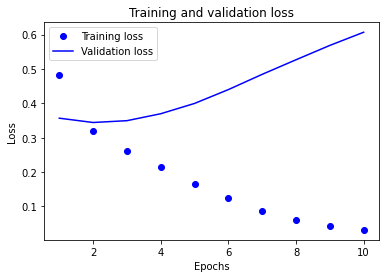

In [23]:
# loss 시각화
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

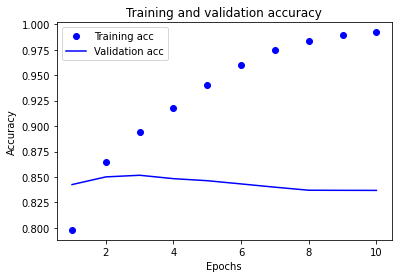

In [24]:
plt.clf()  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<hr>

## 학습된 Embedding 레이어 분석

In [25]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(15000, 200)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지

# 단어 개수 만큼의 워드 벡터를 파일에 기록 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("감동")

[('정말', 0.5148522257804871),
 ('영화', 0.4831978678703308),
 ('는데', 0.44467973709106445),
 ('에서', 0.44009929895401),
 ('내내', 0.4360922574996948),
 ('기억', 0.4360300302505493),
 ('즐거운', 0.4321631193161011),
 ('언제나', 0.4305128753185272),
 ('고', 0.4297395944595337),
 ('네요', 0.42896953225135803)]

감동이라는 단어와 유사한 단어와 유사도를 확인해보았다. 유사도가 높은 단어들이 많지 않았고 직접 확인해 본 결과 이들이 유사한 단어라고도 할 수 없었다.

<hr>

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [28]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['감동']

word2vec.similar_by_word("감동")

/tmp/ipykernel_6908/1081681440.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['감동']
/tmp/ipykernel_6908/1081681440.py:9: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("감동")


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

이전과 동일한 단어인 '감동'과 유사한 단어와 유사도를 확인해본 결과 확실히 개선된 것으로 보인다.

In [29]:
from tensorflow.keras.layers import Dropout

vocab_size = 15000    # 어휘 사전의 크기입니다(15,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 copy
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

/tmp/ipykernel_6908/2381438500.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6908/2381438500.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 3,468,225
Trainable params: 3,468,225
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3463/3463 [==============================] - 24s 7ms/step - loss: 0.4385 - accuracy: 0.7822 - val_loss: 0.3352 - val_accuracy: 0.8507
Epoch 2/5
3463/3463 [==============================] - 22s 6ms/step - loss: 0.3065 - accuracy: 0.8698 - val_loss: 0.3225 - val_accuracy: 0.8590
Epoch 3/5
3463/3463 [==============================] - 22s 6ms/step - loss: 0.2552 - accuracy: 0.8948 - val_loss: 0.3327 - val_accuracy: 0.8577
Epoch 4/5
3463/3463 [==============================] - 22s 6ms/step - loss: 0.2100 - accuracy: 0.9163 - val_loss: 0.3628 - val_accuracy: 0.8542
Epoch 5/5
3463/3463 [==============================] - 22s 6ms/step - loss: 0.1693 - accuracy: 0.9340 - val_loss: 0.4200 - val_accuracy: 0.8528


In [31]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.4208 - accuracy: 0.8510
[0.4208180904388428, 0.8509848117828369]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


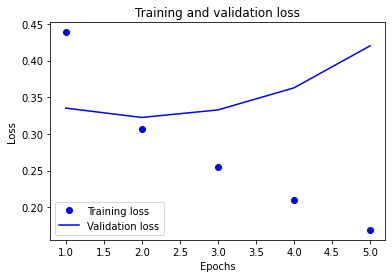

In [32]:
# loss 시각화
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

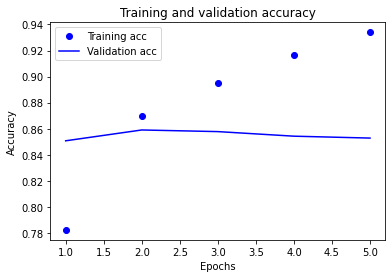

In [33]:
plt.clf()  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<hr>

## <프로젝트 회고>

이번 프로젝트는 기존에 진행했었던 NLP와는 다르게 한글 텍스트를 활용한 작업이었다는 것이 새롭게 느껴졌다. 물론 한국어의 특성상 데이터로더를 구성하는 과정이 영어보다는 조금 번거로웠다. 한 단어가 여러 의미를 포함하기도 하고 하나의 의미를 다양한 단어로 표현이 가능하기 때문에 한국어 텍스트를 다루는 NLP가 영어보다는 더 어려운 것 같다. 다행히 사전학습된 한국어 임베딩을 활용하여 모델의 성능을 높일 수 있었다. Google에서 제공하는 Word2Vec를 활용하였고 처음 적용시켰을 때에는 '감동'이라는 단어와 유사도가 높은 단어들을 확인한 결과 그리 높지 않은 단어들이 출력되었고 '정말', '영화', '는데' 등 유사성이 전혀 없는 단어들이었다. 그 다음은 한국어 임베딩을 적용시켰다. 확실히 유사도가 높은 단어들이 출력되었고 '감격', '감명', '실망' 등의 유사하다고 볼 수 있는 단어들이었다.

이번 프로젝트에서 힘들었던 점은 중간에 발생했던 다양한 오류들이었다. 파일을 불러오는 과정, 한국어 임베딩을 하는 과정, 모델을 학습시키는 과정 등에서 오류가 발생하였고 이를 해결하기 위해 구글링을 하면서 많은 시간을 낭비했던 것 같다. 이번에 발생했던 오류들은 블로그 등을 통해 정리하여 다음에 또 다시 발생했을 때 시간을 절약할 수 있도록 하려고 한다. 

두 번째로 힘들었던 점은 정확도였다. 이번 프로젝트에서 목표로 하는 정확도는 85%이상이었지만 약간의 부족함으로 계속해서 넘지를 못했다. 또한 loss와 accuracy를 시각화한 그래프를 살펴보면 다른 프로젝트 때와는 다르게 에포크가 낮은 시점부터 Training과 validation의 그래프에 이격이 발생했다. 나는 overfitting이 원인이었다고 생각했고 모델의 복잡도를 최소화하기 위해 레이어를 줄이고 DML시간에 배운 dropout을 사용해보았다. 한국어 임베딩을 사용하고  초반에는 83% 정도의 정확도가 나왔고 레이어를 최소화하고 하이퍼 파라미터를 수정한 결과 84%이상의 정확도를 보였다. 하지만 아무리 수정을 해도 85%를 넘지 못했고 마지막으로 사전의 크기를 10,000개에서 15,000개로 수정해주었다. 결과적으로는 85.1%가 나왔다. 

목표로 하는 정확도에 도달하기는 했지만 이 것이 올바른 방법이었는지는 잘 모르겠다. 교육을 통해 이론으로는 과적합을 해결하는 방법들을 배웠었지만 이것을 실제 모델에 적용시키는 과정이 쉽지만은 않았다. 또한 여러 오류들을 마주하면서 해결하기 위해 찾아보는 과정에서 정말 많은 것을 배웠다. 점점 프로젝트가 어려워지고 있는 것을 느끼지만 그만큼 많이 배우면서 성장하고 있는 것 같다.  